# Product Image Recognition  - Machine Learning

In the Consumer Packaged Goods (CPG) industry, product images are becoming popular in web based applications and planogramming tools. Use of  images and alternate views of products enhance user experience and are sometimes more intuitive than textual product descriptions. However it becomes cumbersome and expensive to manage, track and catalog millions of product images manually. The objective of this project is to test and compare various machine learning techniques to classify and label product images into product categories.  

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
#################################################################
# Import packages 
#################################################################
import sys
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

from skimage import data, io, filters, feature
from skimage.color.colorconv import rgb2grey
from skimage.transform import resize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm, neighbors, preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, auc
from sklearn.decomposition import PCA

## Read Images

100 front-facing product images in the PNG format and corresponding text labels stored in a CSV file are read into memory. Fig 1 below shows the distribution of the 8 retail categories in the image data set.

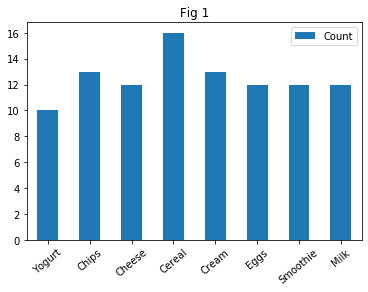

In [3]:
#read ordered labels from CSV file 
labels = pd.read_csv("../data/images/labels.csv")
y = labels.values.ravel()
df = pd.DataFrame.from_dict(Counter(y), orient='index')
df.columns = ['Count']
df.plot(kind='bar', figsize = (6,4), title = "Fig 1")
locs, labels_text = plt.xticks()
plt.setp(labels_text, rotation=40)
plt.show()

## Feature Engineering

Since each of the product categories have distinct object shapes, edge detection algorithms are expected to perform well in extracting features for this classification problem. [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) and [Canny](https://en.wikipedia.org/wiki/Canny_edge_detector) edge detection techniques are applied on a low resolution sample of the raw image files. Some of the processed images are visually compared below to verify the results of edge detection. The Sobel algorithm will be selected to process images because, unlike Canny, it places more emphasis on the edges and captures the essential features for shape recognition. 

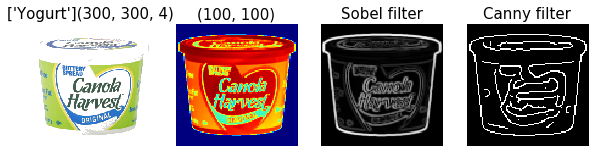

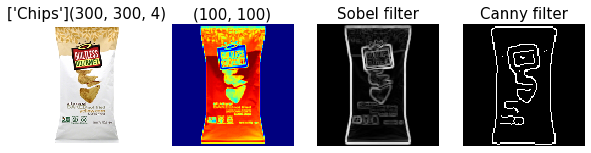

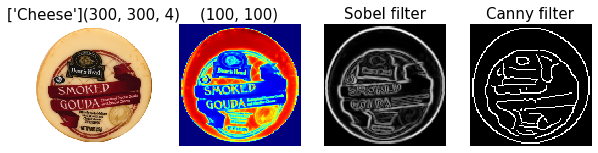

In [4]:
#################################################################
# Read and Process images 
#################################################################
imgs_shaped = []
#global constants
TITLE_SIZE = 15
RANDOM_STATE = 17
IMG_DIM = 100
SAMPLE_SIZE = 100

#read images in order
for i in range(1,SAMPLE_SIZE+1):
    img = io.imread('../data/images/' + str(i) + '.png')
    
    #resize image to lower resolution
    img_grey = rgb2grey(img)
    img_resized = resize(img_grey, (IMG_DIM, IMG_DIM))
    
    #apply filters
    img_sobel = filters.sobel(img_resized)
    img_canny = feature.canny(img_resized, sigma=2) 

    #sample some image feature extraction
    if i < 4:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
        
        ax1.imshow(img, cmap=plt.cm.jet)
        ax1.axis('off')
        ax1.set_title(str(labels.values[i-1]) + str(img.shape) , fontsize = TITLE_SIZE)

        ax2.imshow(img_resized, cmap=plt.cm.jet)
        ax2.axis('off')
        ax2.set_title(str(img_resized.shape), fontsize = TITLE_SIZE)

        ax3.imshow(img_sobel, cmap=plt.cm.gray)
        ax3.axis('off')
        ax3.set_title('Sobel filter' , fontsize = TITLE_SIZE)

        ax4.imshow(img_canny, cmap=plt.cm.gray)
        ax4.axis('off')
        ax4.set_title('Canny filter' , fontsize = TITLE_SIZE)

    #select the Sobel filter
    imgs_shaped.append(img_sobel.ravel())
#end-for

#Convert all images to NP array         
imgs_shaped = np.asarray(imgs_shaped) 
#set X values
X = imgs_shaped

## What does the classifer see ?

**Pixel importances** - Since we are dealing with raw images, it is useful to see how a classifier extracts the important features. In Fig 3, the 2D image data was fit to an ExtraTreesClassifier to determine pixels importances for classification. The brighter pixels are given more weightage by the classifier. The number of estimators are increased to get a better picture.

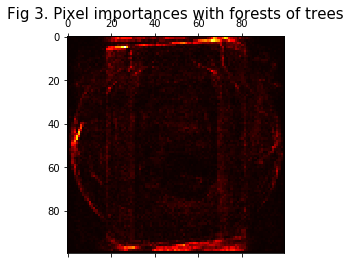

In [5]:
#################################################################
# Build a forest and compute the pixel importances 
#################################################################
forest = ExtraTreesClassifier(n_estimators=4000, n_jobs=1, random_state=RANDOM_STATE)
forest.fit(X, y)
importances = forest.feature_importances_
importances = importances.reshape(IMG_DIM, IMG_DIM)

# Plot pixel importances
_, ax = plt.subplots(figsize=(4, 4))
ax.matshow(importances, cmap=plt.cm.hot)
plt.title("Fig 3. Pixel importances with forests of trees", fontsize = TITLE_SIZE)
plt.show()

## Build Models

An ensemble of classification models would be fit to a training images dataset and tested against a test dataset. Where applicable, exhaustive grid search using GridSearchCV is used to scan a range of parameters to obtain best results using N-fold cross-validation. 

The data is split into training 70% and 30% test sets. Fig 5 shows distribution of the train and test data.

In [6]:
#split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)

#create binarized labels
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.fit_transform(y_test)

#Ensure that the random test sample sees all the labels
print ("Total dataset X:", X.shape, "y:", len(y))
print ("Training set:", X_train.shape, "Testing set:" , X_test.shape)
assert(y_test_bin.shape[1] == y_train_bin.shape[1])

Total dataset X: (100, 10000) y: 100
Training set: (70, 10000) Testing set: (30, 10000)


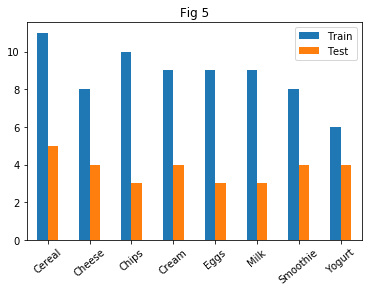

In [7]:
#Plot train and test label frequencies
df1 = pd.DataFrame.from_dict(Counter(y_train), orient='index')
df2 = pd.DataFrame.from_dict(Counter(y_test), orient='index')
df = pd.concat([df1, df2], axis=1, sort=True)
df.columns=['Train', 'Test']
df.plot(kind='bar', figsize = (6,4), title = "Fig 5")
locs, labels_text = plt.xticks()
plt.setp(labels_text, rotation=40)
plt.show()

### Define Classifiers

Although certain models such as Neural Networks and Trees are known to outperform other methods for image classification, we will compare various methods in the list below during the modeling process. The best estimators from Grid Search can be seen in the [Appendix](#Appendix). In addition to train-test split, we will apply a 3-fold cross-validation for the grid search. Also, given the analysis above, the estimator size will be set to 100. Since computation is being run on a Windows platform it will run single-threaded given known limitations of iPython.

In [12]:
#################################################################
# Declare model parameters and search ranges
#################################################################
N_ESTIMATORS =  100
CV = 3
N_JOBS = 1
BATCH_SIZE = 30
NUM_EPOCHS = 50
NUM_HIDDEN_UNITS = 400
LEARNING_RATE = 0.01
MOMENTUM = 0.7 

C_range = [1e-2, 1e1, 1e3,1e5]
gamma_range = [1e-4, 1e-2, 1, 1e2, 1e4]
degree_range = [2,3,4]
learning_rate_range = [0.001, 0.01, 0.1]

svm_param_grid = [
    {"C" : C_range, "kernel": ['linear']},
    {"C" : C_range, "gamma" : gamma_range, "kernel": ['rbf']},
    {"C" : C_range, "gamma" : gamma_range, "degree" : degree_range, "kernel": ['poly']}
]

In [13]:
#################################################################
# Declare classifiers using parameters above
#################################################################
classifiers ={
    "SVM" : GridSearchCV(svm.SVC(probability=True), param_grid = svm_param_grid, iid=False, 
                         n_jobs= N_JOBS, cv = CV, refit=True),
    
    "LogisticRegression": GridSearchCV(LogisticRegression(multi_class='multinomial', solver='lbfgs'),
                                       param_grid = [{"C" : C_range}], n_jobs= N_JOBS, iid=False, cv = CV, refit=True),
    
    "RandomForest":  RandomForestClassifier(n_estimators = N_ESTIMATORS),
    
    "GradientBoosting": GridSearchCV(GradientBoostingClassifier(n_estimators = N_ESTIMATORS), 
                                     param_grid = [{"learning_rate" : learning_rate_range}]
                                     , n_jobs= N_JOBS, cv = CV,  iid=False, refit=True),
}

In [14]:
#define metrics
metrics = pd.DataFrame(columns=['Classifier', 'Test Score', 'Train Score', 'Train Time'])

#define output reports
confusion_matrices = {}
classification_reports = {}

#iterate through all classifiers
for name,clf in classifiers.items():
    print ("Fitting" , name)
    
    #train
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    train_preds = clf.predict(X_train)

    #test
    t1 = time()
    test_preds = clf.predict(X_test)
    test_time = time() - t1

    #accuracy score
    test_score = accuracy_score(y_test,test_preds)
    train_score = accuracy_score(y_train,train_preds)

    #confusion matrix
    confusion_matrices[name] =  pd.crosstab(index=y_test, columns=test_preds.ravel(), rownames=['True'], colnames=['Predicted'])
    #classification report
    classification_reports[name] =  classification_report(y_test,test_preds)

    #generate metrics
    metrics = metrics.append({'Classifier' : name, 'Test Score' : test_score, 'Train Score' : train_score, 'Train Time' : train_time},
                         ignore_index=True) 

Fitting SVM
Fitting LogisticRegression
Fitting RandomForest
Fitting GradientBoosting


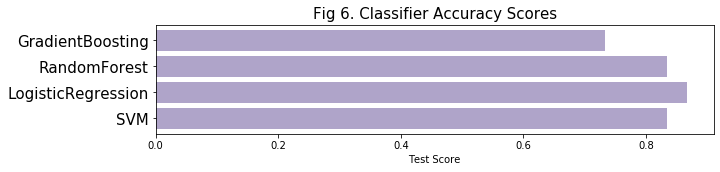

In [15]:
# Plot Accuracy Scores
y_pos = np.arange(len(metrics)) 
plt.figure(figsize=(10, 2))
plt.barh(y_pos, metrics['Test Score'] ,align='center', alpha=0.6, color='#7A68A6')
plt.yticks(y_pos, metrics['Classifier'],fontsize = TITLE_SIZE)
plt.xlabel('Test Score')
plt.title('Fig 6. Classifier Accuracy Scores', fontsize = TITLE_SIZE)
plt.show()

In [16]:
metrics.sort_values(by=['Test Score'], ascending=[0])

,Classifier,Test Score,Train Score,Train Time
1,LogisticRegression,0.866667,1.0,6.861611
0,SVM,0.833333,1.0,87.037235
2,RandomForest,0.833333,1.0,0.286234
3,GradientBoosting,0.733333,1.0,114.495968


### Confusion Matrices

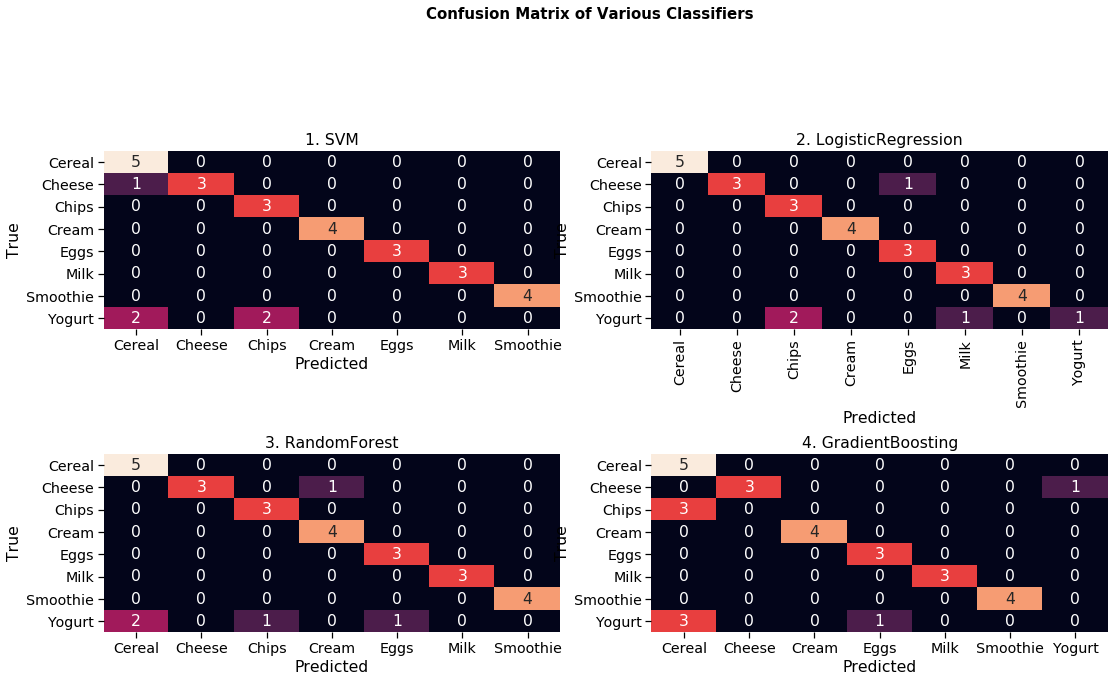

In [17]:
# Plot Confusion Matrices
fix, ax = plt.subplots(figsize=(18, 20))
plt.suptitle('Confusion Matrix of Various Classifiers', fontsize=TITLE_SIZE, fontweight='bold')
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})
i = 0
for name, matrix in confusion_matrices.items():
    i += 1
    plt.subplot(4,2, i)
    plt.title(str(i) + ". " + name)
    sns.heatmap(matrix, annot=True, square=False, fmt='', cbar=False)
    plt.subplots_adjust(hspace=.7)  


### Classification Report

In [18]:
#################################################################
# Print Classification Reports
#################################################################
for name, matrix in classification_reports.items():
    print ("----------------------------------------------------------")
    print (name)
    print ("----------------------------------------------------------")
    print (matrix)

----------------------------------------------------------
SVM
----------------------------------------------------------
              precision    recall  f1-score   support

      Cereal       0.62      1.00      0.77         5
      Cheese       1.00      0.75      0.86         4
       Chips       0.60      1.00      0.75         3
       Cream       1.00      1.00      1.00         4
        Eggs       1.00      1.00      1.00         3
        Milk       1.00      1.00      1.00         3
    Smoothie       1.00      1.00      1.00         4
      Yogurt       0.00      0.00      0.00         4

    accuracy                           0.83        30
   macro avg       0.78      0.84      0.80        30
weighted avg       0.76      0.83      0.78        30

----------------------------------------------------------
LogisticRegression
----------------------------------------------------------
              precision    recall  f1-score   support

      Cereal       1.00      1.00  

## Holdout Testing

In [19]:
imgs_raw = []
imgs_test = []

#read unlabeled images
TEST_IMAGES = 30
for i in range(1,TEST_IMAGES+1):
    img = io.imread('../data/images/' + str(i) + '.png')
    imgs_raw.append(img)
    #resize image to lower resolution
    img_grey = rgb2grey(img)
    img_resized = resize(img_grey, (IMG_DIM, IMG_DIM))
    #apply filters
    img_sobel = filters.sobel(img_resized)
    img_shaped = img_sobel.ravel()
    imgs_test.append(img_shaped)

#collect all test images    
imgs_test = np.asarray(imgs_test)

### Selected Classifiers

In [20]:
#################################################################
# Print Best Classifiers selected in Grid Search
#################################################################
for name,clf in classifiers.items():
    try:
        print ("----------------------------------------------------------")
        print (name)
        print ("----------------------------------------------------------")
        print (clf.best_estimator_)
    except:
        print (clf)
        continue

----------------------------------------------------------
SVM
----------------------------------------------------------
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
----------------------------------------------------------
LogisticRegression
----------------------------------------------------------
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
----------------------------------------------------------
RandomForest
----------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_we

### Logistic Regression Classifier

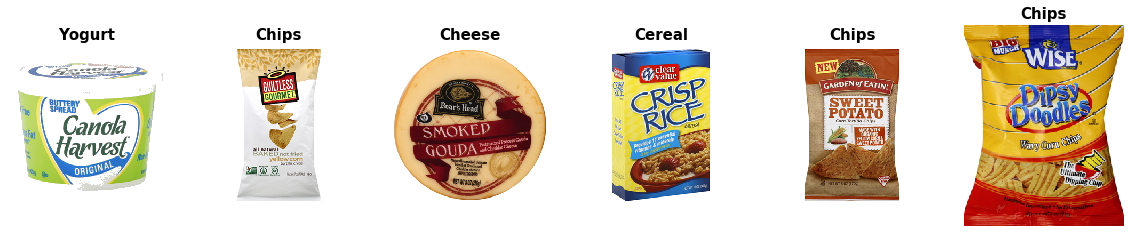

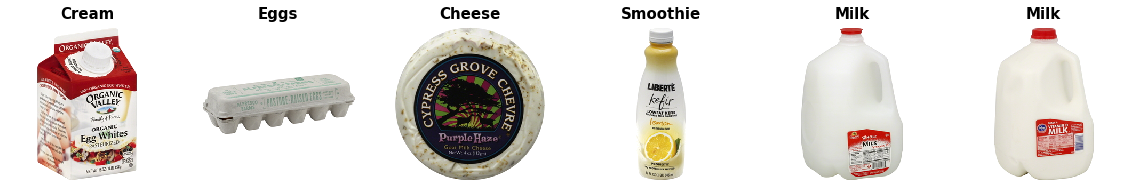

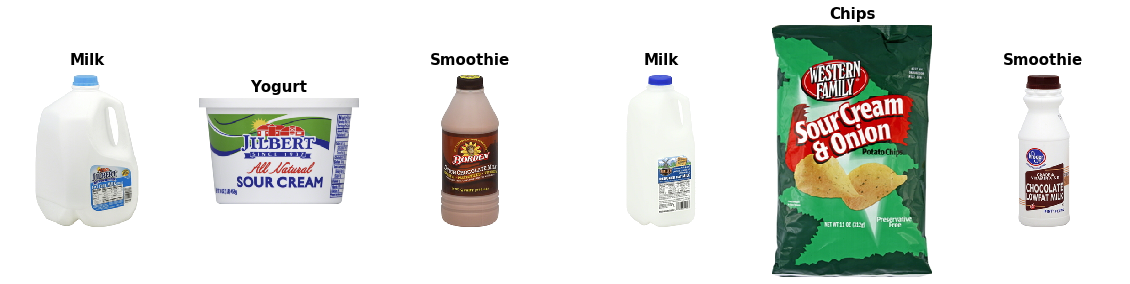

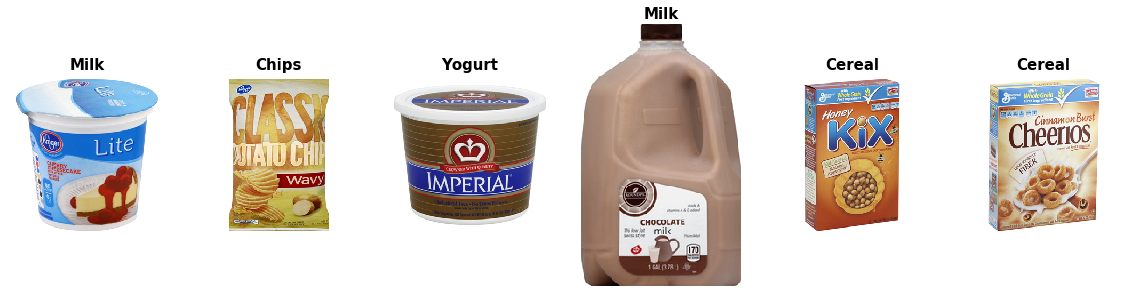

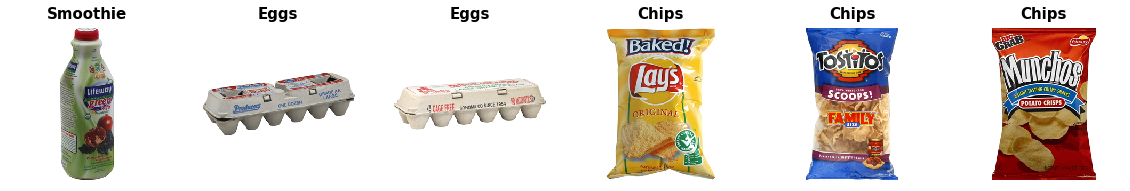

In [21]:
#store the output predictions    
pred_labels = classifiers["LogisticRegression"].predict(imgs_test)

#label images for display
COL_SIZE = 6
for i in range(0,len(imgs_test),COL_SIZE):
    fig, ax = plt.subplots(nrows=1, ncols=COL_SIZE, figsize=(20, 15))
    for j in range(0,len(ax)):
        if i+j < TEST_IMAGES:
            ax[j].imshow(imgs_raw[i+j], cmap=plt.cm.jet)
            ax[j].axis('off')
            ax[j].set_title(pred_labels[i+j], fontsize = TITLE_SIZE, fontweight='bold')

## Conclusion

The tests were run with and without image filters. The use of a Sobel filter on the images helped improved the test accuracy scores. Other image processing techniques such use of pixel distribution histograms instead of raw pixels could also be applied. 

Although most classifiers are able to distinguish beween well differentiated shapes such as "Eggs" and "Smoothie", classifing similar-shaped images of "Chips", "Yogurt" and "Cereal" is challenging. Some improvement was seen by selecting better training samples and applying cross-validation, but further work needs to be done.    